In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [54]:
def getData(fips):
    
    # Cleaning and retrieving demographics data
    dem = pd.read_csv('countydemographics/county_demographics.csv')
    dem = dem.loc[dem['fips'] == float(fips)]
    cols = [0,2,3,4,5,6,9,10,11]
    dem = dem.drop(dem.columns[cols], axis=1)
    med_age = dem['median_age'].values[0]
    pop_den = dem['Density per square mile of land area'].values[0]
    
    # Cleaning and retrieving mobility data
    mob = pd.read_csv('applemobilitydata/applemobilitycleaned_county.csv')
    mob = mob.loc[mob['fips'] == float(fips)]
    cols = [0,2,3]
    mob = mob.drop(mob.columns[cols], axis=1)
    mob = mob * med_age * pop_den
    
    # Cleaning and retrieving symptoms data
    sym = pd.read_csv('covidsymptoms/covidsymptoms_google.csv')
    sym = sym.loc[sym['fips'] == float(fips)]
    cols = [0,2,3]
    sym = sym.drop(sym.columns[cols], axis=1)
    
    # Cleaning and retrieving testing rate data
    tes = pd.read_csv('testingrates/testing_rates_county.csv')
    tes = tes.loc[tes['fips'] == float(fips)]
    cols = [0]
    tes = tes.drop(tes.columns[cols], axis=1)
    
    # Cleaning and retrieving case data
    cas = pd.read_csv('covidstats/confirmed_cases_county.csv')
    cas = cas.loc[cas['fips'] == float(fips)]
    cols = [0]
    cas = cas.drop(cas.columns[cols], axis=1)
    
    if mob.shape[0] == 0 or dem.shape[0] == 0 or sym.shape[0] == 0 or tes.shape[0] == 0 or cas.shape[0] == 0:
        print('Missing one or more data for county, please use another county.')

    return dem, mob, sym, tes, cas

In [55]:
def prepareData(dem, mob, sym, tes, cas):
    newX = pd.concat([mob,sym])
    newX = newX.reset_index()
    newX = newX.drop(newX.columns[[0,1]], axis=1)
    
    newY = pd.concat([cas])
    newY = newY.reset_index()
    newY = newY.drop(newY.columns[[0,1]], axis=1)
    
    newX = newX.T
    newY = newY.T
    newX = newX.fillna(0)
    newY = newY.fillna(0)
    
    X = newX[[0,1]]
    y = newY[[0]]
    
    # Moving averages

    X[0] = X[0].rolling(window=4).mean().dropna()
    X[1] = X[1].rolling(window=2).mean().dropna()

    X[0] = X[0].shift(6).dropna()
    X[1] = X[1].shift(4).dropna()

    X = X[X.index.isin(y.index)]
    y = y[y.index.isin(X.index)]
    X = X.fillna(0)
    y = y.fillna(0)
    
    X = StandardScaler().fit_transform(X)
    y = StandardScaler().fit_transform(y)
    y = np.reshape(y, (y.shape[0],))
    
    return X, y

In [56]:
X, y = prepareData(*getData('36061'))

In [57]:
# Gaussian Process Regression

In [58]:
import sklearn.gaussian_process as gp
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
regressor = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
model = regressor.fit(X, y)

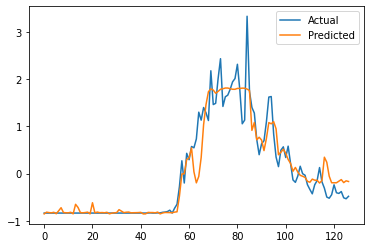

In [59]:
y_pred = regressor.predict(X)
df = pd.DataFrame({'Actual': y.flatten(), 'Predicted': y_pred.flatten()})
df.plot()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(X)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

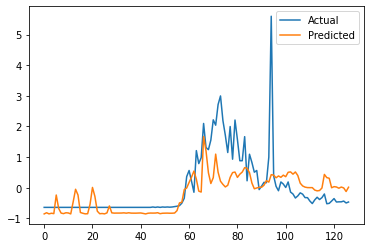

In [60]:
X, y = prepareData(*getData('36087'))
y_pred = regressor.predict(X)
df = pd.DataFrame({'Actual': y.flatten(), 'Predicted': y_pred.flatten()})
df.plot()